In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [129]:
def shorten(arr, factor=10):
    arr_shape = list(arr.shape)
    arr_shape[0] = int(arr_shape[0]/factor)
    new_arr = np.zeros(arr_shape)
    for i in range(arr_shape[0]):
        new_arr[i] = arr[i*factor]
    return new_arr

In [182]:
# Change here for different observation gap and observation covariance parameter
mu=4.0
ob_gap=0.01

os.chdir('/home/shashank/Documents/Data Assimilation/ENKF_for_CLVs/data')
#factor in time
#Partial or full observation
ob_dim=1
ens_cov=4.0 
bias=6.0     

#load the state
state=np.load('Trajectory_{}_T={}.npy'.format(0.01,500))
#state=shorten(np.load('Trajectory_{}_T={}.npy'.format(0.01,500)),factor=5)

k=1
N=40 
l_scale=0
alpha=1.1

# State and obs
os.chdir(os.getcwd()+'/ob{}'.format(k)) 
obs=np.load('ob{}_gap_{}_H1__mu={}_obs_cov1.npy'.format(k,ob_gap,mu))

#Go inside the data folder......................................
file_label='bias={}_obs={}_ens={}_Mcov={},ocov={}_,gap={}_alpha={}_loc=none_r={}'.format(bias,ob_dim,N,ens_cov,mu,ob_gap,alpha,l_scale)
os.chdir(file_label)

#Load data....
f_ens=np.load(file_label+'f_ensemble.npy')
a_ens=np.load(file_label+'a_ensemble.npy') #ens has shape:=[time steps,system dimension,ensemble number]
f_mean=np.mean(f_ens,axis=2)
a_mean=np.mean(a_ens,axis=2)
#time=np.load(file_label+'time.npy')

In [183]:
time=ob_gap*np.arange(f_mean.shape[0])

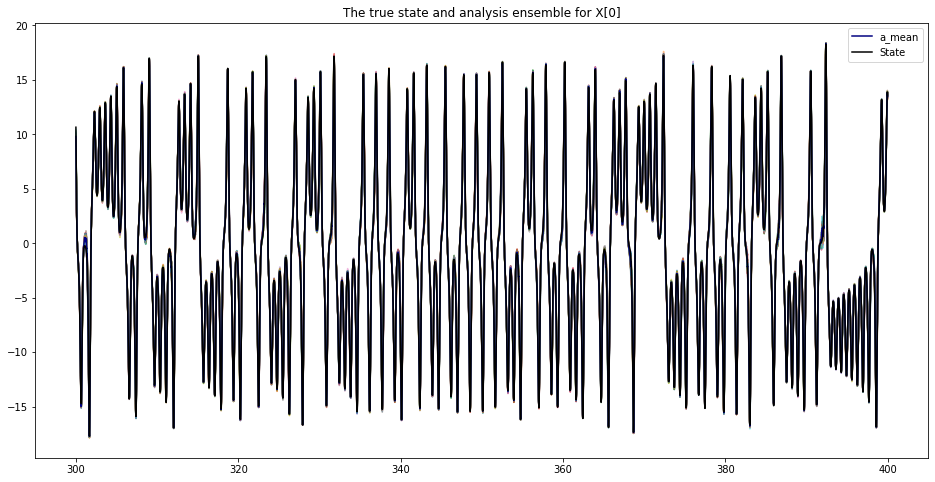

In [210]:
plt.figure(figsize=(16,8))
# Start time and end time chosen to view a part of time series
t_start=30000
t_stop=40000
# component to view
comp_=0

#plt.ylim(-15,15)
#for i in range(15):
plt.plot(time[t_start:t_stop],a_ens[t_start:t_stop,comp_],linestyle='solid',alpha=0.5) 
plt.plot(time[t_start:t_stop],a_mean[t_start:t_stop,comp_],c='navy',alpha=1,label='a_mean')

#plt.plot(time[t_start:t_stop],f_mean[t_start:t_stop,comp_],c='blue',alpha=0.5,label='f_mean')
plt.plot(time[t_start:t_stop],state[t_start:t_stop,comp_],c='black',label='State')
#if (comp_%2!=0):
#    plt.errorbar(time[t_start:t_stop], obs[t_start:t_stop,int(comp_/2)], yerr=np.sqrt(mu), fmt='o',alpha=1, color='indigo',
#                    ecolor='saddlebrown', elinewidth=1, markersize=2)
#plt.scatter(time[t_start:t_stop],obs[t_start:t_stop,comp_-1],c='r',marker='.',label='obs')
    
plt.legend()
plt.title(r'The true state and analysis ensemble for X[{}]'.format(comp_))
#plt.xticks(time[t_start:t_stop],fontsize=12)
plt.legend(frameon='True')

## L2-error over time

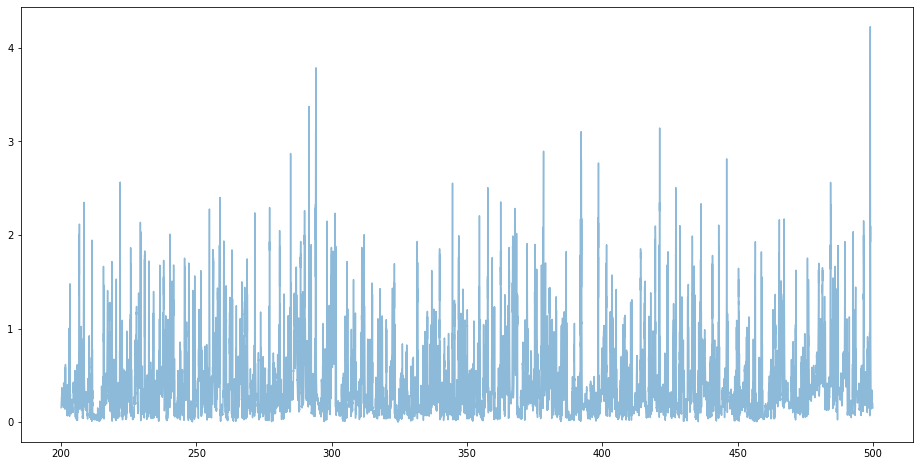

In [217]:
plt.figure(figsize=(16,8))
t_start=20000
t_stop=50000
plt.plot(time[t_start:t_stop],np.sqrt(np.sum((state[t_start:t_stop]-a_mean[t_start:t_stop])**2,axis=1)),linestyle='solid',alpha=0.5) 

## Error in the estimated jacobian

In [115]:
from jax import grad,jacfwd,jacrev,linearize,vmap,partial,vjp,jvp,jit
import jax.numpy as jnp

In [113]:
# Error in Jacobian is the next important thing
rho = 28.0
sigma = 10.0
beta = 8.0/3.0

#We have the rhs of an ode below
def L63(x):
    "Function to be used for compuation of ode in scipy.integrate.solve_ivp"
    return jnp.array([sigma*(x[1]-x[0]),x[0]*(rho-x[2])-x[1],x[0]*x[1]-beta*x[2]])

Jac_f=jit(jacfwd(L63))

In [116]:
fro_norm=np.zeros(len(time))
for i in range(len(time)):
    J_t_state=Jac_f(state[i])
    J_t_analysis=Jac_f(a_mean[i])
    fro_norm[i]=np.linalg.norm(J_t_state-J_t_analysis,ord='fro')    

Text(0.5, 1.0, 'Error in Jacobian')

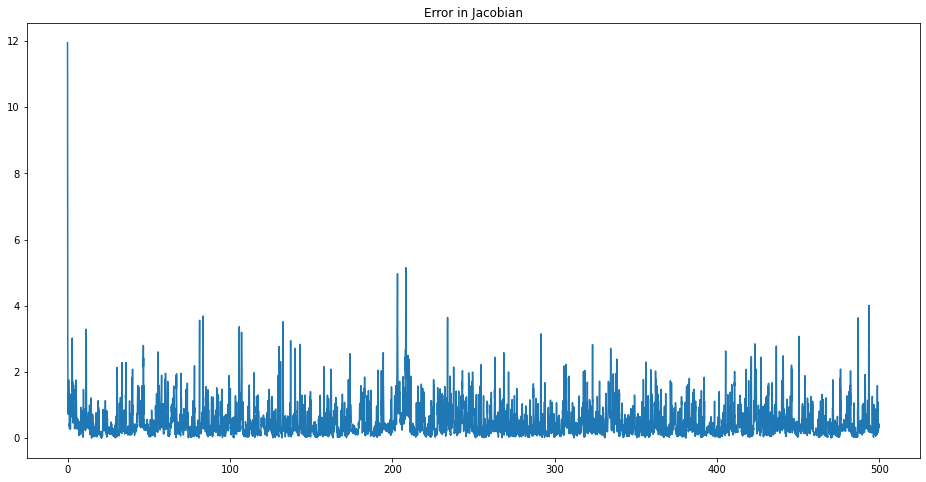

In [118]:
plt.figure(figsize=(16,8))
#plt.yscale('log')
plt.plot(time,fro_norm,label='Gap={}'.format(ob_gap))
plt.title('Error in Jacobian')

In [121]:

os.chdir('/home/shashank/Documents/Data Assimilation/ENKF_for_CLVs/data/ob{}'.format(k))
np.save('frobenius_norm_gap={}.npy'.format(ob_gap),fro_norm.shape)

In [119]:
fro_norm.shape

(10000,)